In [1]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

# Configure quickplot to hide subports
import functools
from phidl import quickplot as qp, set_quickplot_options
import phidl
set_quickplot_options(show_subports = False)

# Layers

Layers are an important component of GDSII design.  Layers in a GDS file are defined using two integers (0-255): a `layer` and a `datatype`.  In PHIDL, the layer can be specified...

 1. as a single number `0`-`255` representing the gds layer number (gds datatype will be set to `0`)
 2. as a 2-element list `[0,1]` or tuple `(0,1)` representing the (layer, datatype)
 3. as a Layer / LayerSet object

To begin, let's make a new blank device `D` and add some text-polygons to it using different methods of layer entry:

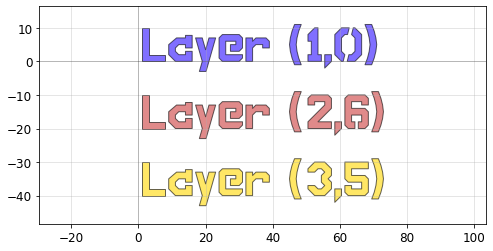

In [2]:
import phidl.geometry as pg
from phidl import Device, Layer, LayerSet
from phidl import quickplot as qp


D = Device()

# Specify layer with a single integer 0-255 (gds datatype will be set to 0)
layer1 = 1

# Specify layer as 1, equivalent to layer = 2, datatype = 6
layer2 = (2,6)

# Specify layer as 2, equivalent to layer = 2, datatype = 0
layer3 = Layer(gds_layer = 3, gds_datatype = 5, color = 'gold')

D << pg.text('Layer (1,0)', layer = layer1)
D << pg.text('Layer (2,6)', layer = layer2).movey(-20)
D << pg.text('Layer (3,5)', layer = layer3).movey(-40)

qp(D)

## Multiple layers

Say we want to create the same ellipse on several different layers.  We can do that by using a Python `set` of layers, which is created using the curly brackets `{}` (similar to a dict but without colons).  So if we want to add it to four layers, say:
- layer 1 / datatype 0
- layer 3 / datatype 5
- layer 3 / datatype 6
- layer 7 / datatype 1

In [3]:
# Note each element of the set must be a valid layer input by itself
my_layers = {1, (3,5), (3,6), (7,8)}
D = pg.ellipse(layer = my_layers)

Note that although we specified four different layers, it did **not** produce four separate ellipse Devices--instead, it produced one Device with all four ellipse polygons inside that single Device.

### LayerSet

PHIDL also has a convenience container for layers called a `LayerSet`, which lets you conveniently call each Layer object just by its name.  You can also specify the layer color using an RGB triplet e.g `(0.1, 0.4, 0.2)`, an HTML hex color (e.g. `#a31df4`), or a CSS3 color name (e.g. `'gold'` or `'lightblue'` see http://www.w3schools.com/colors/colors_names.asp ) The `'alpha'` argument also lets you specify how transparent that layer should look when using `quickplot()` (has no effect on the written GDS file).

We construct a layerset by starting with a blank one, and then using the `add_layer()` function:

In [4]:
ls = LayerSet() # Create a blank LayerSet

ls.add_layer(name = 'au', gds_layer = 4, gds_datatype = 0, 
             description = 'Gold wiring', color = 'goldenrod')
ls.add_layer(name = 'nb', gds_layer = 5, gds_datatype = 0, 
             description = 'Niobium liftoff', color = (0.4,0.5,0.7))
ls.add_layer('nb_etch', 6, 0, color = 'lightblue', alpha = 0.2)
ls.add_layer('silicon', 8, 2, color = 'green', alpha = 0.4)

Now that our layers are defined, we can call them from the LayerSet in the same way we would from a dictionary, where the name becomes the key:

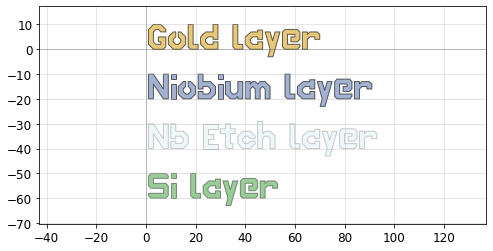

In [5]:
D = Device()

gold_layer = ls['au']

D.add_ref( pg.text('Gold layer', size = 10, layer = ls['au']) ).movey(0)
D.add_ref( pg.text('Niobium layer', size = 10, layer = ls['nb']) ).movey(-20)
D.add_ref( pg.text('Nb Etch layer', size = 10, layer = ls['nb_etch']) ).movey(-40)
D.add_ref( pg.text('Si layer', size = 10, layer = ls['silicon']) ).movey(-60)

qp(D)

We can additionally use a LayerSet to add the same structure to several layers at once by passing the whole layerset to the layer argument.  Note that since they all overlap, it will look like a single object (but rest assured there are multiple layers)

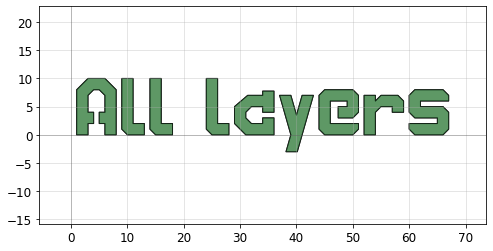

In [6]:
T = pg.text('All layers', layer = ls)
qp(T)

If we want to examine any single layer, we can call them by their names,
for example

In [7]:
print(ls['nb'])

Layer (name nb, GDS layer 5, GDS datatype 0, description Niobium liftoff, color #6680b2)


We can quickly preview our color scheme using the pg.preview_layerset() function as well.

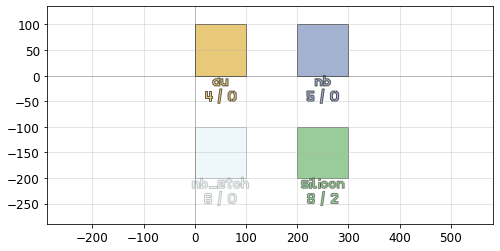

In [8]:
D = pg.preview_layerset(ls)
qp(D)

### Making KLayout .lyp files

We can even save the LayerSet as a KLayout .lyp file ("layer properties" file), useful for getting the color scheme in KLayout to match quickplot

In [9]:
import phidl.utilities as pu
pu.write_lyp('my_layer_properties_file.lyp', layerset = ls)

### Ignoring layers with None

In some cases, you may want to not use one of the layers for a given geometry.  PHIDL makes that easy by letting you pass `None` to any function that accepts layers.  For instance, say we have the following structure with three distinct layers

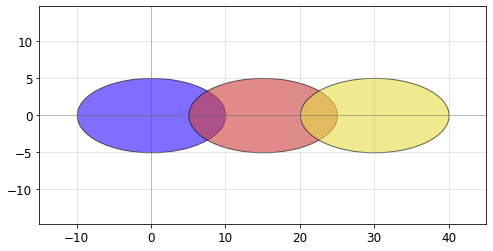

In [10]:
def many_ellipses(layer1 = 1, layer2 = 2, layer3 = 3):
    D = Device()
    D << pg.ellipse(layer = layer1)
    D << pg.ellipse(layer = layer2).movex(15)
    D << pg.ellipse(layer = layer3).movex(30)
    
    return D

qp(many_ellipses(layer1 = 1, layer2 = 2, layer3 = 3))

Now say we want to remove the middle layer entirely.  We note that it's defined by the layer `layer2`, so we can set that to `None` and it won't be added at all:

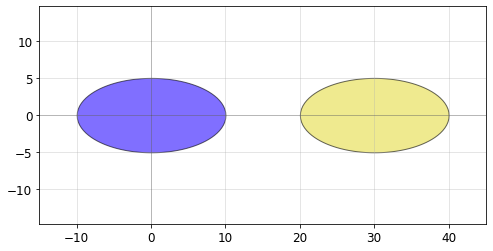

In [11]:
qp(many_ellipses(layer1 = 1, layer2 = None, layer3 = 3))

## Removing layers

We can remove the unwanted layers using the `remove_layers()` function.  Let's again start with our `pg.preview_layerset()` Device above:

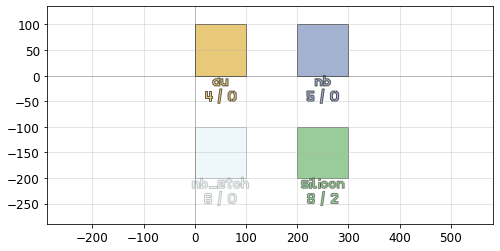

In [12]:
D = pg.preview_layerset(ls)
qp(D)

 Now let's remove layers 6 and 8.  This should leave us with just the gold (layer 4,0) and nb (5,0) layers. 

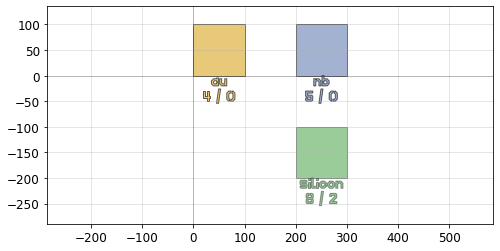

In [13]:
D.remove_layers(layers = [6,8])
qp(D)

Whoops! Note that because we specified just an `8` as the layer we wanted to remove, PHIDL interpreted it as  `(8,0)`, so it didn't remove the the silicon layer that is actually on `(8,2)`.  Let's try again:

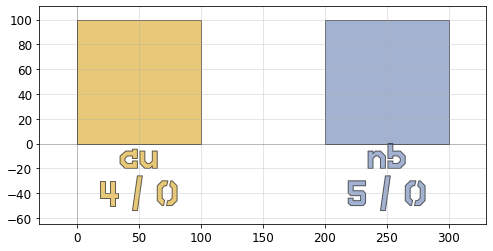

In [14]:
D.remove_layers(layers = [(8,2)])
qp(D)

That's better.

If we later decide that we actually **only** want layer 4, we can do that too.  To do so, we set "invert_selection" to True so that all layers **except** 4 are removed:

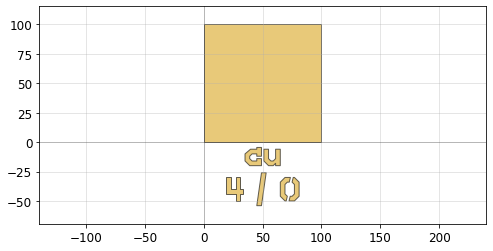

In [15]:
D.remove_layers(layers = [4], invert_selection = True)
qp(D)

## Remapping (moving) layers


We can use the `remap_layers()` function to map layers arbitrarily. We'll start again with our layerset_preview device:

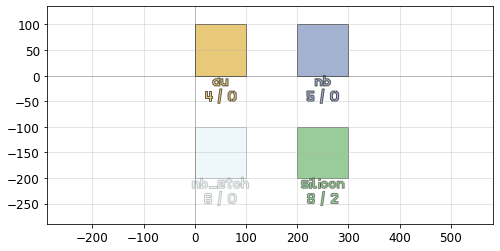

In [16]:
D = pg.preview_layerset(ls)
qp(D)

Now say that we wanted to move shapes on the silicon layer `(8,2)` to layer 99, and nb_etch layer `(6,0)` to layer 77 but leave the other layers alone.  We do this by construction a python dictionary and passing to `remap_layers()`

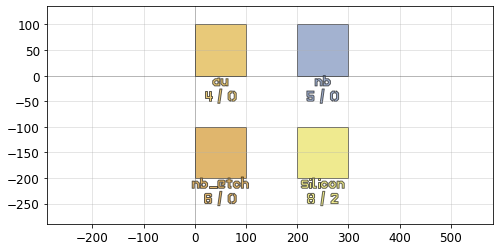

In [17]:
D.remap_layers(layermap = {(8,2): 99,
                             6  : 77,
                           })
qp(D)

Very good!  We can see from the colors of the bottom polygons changing that the layer remapping worked.

## Extracting / copying layers

### Extracting layers

Say you want to access or copy all the polygons of specific layer(s) from an existing Device. You can do this using the `pg.extract()` function, which will copy layers out of one Device and put them into a new Device.

Let's start with a Device with a few objects in it:

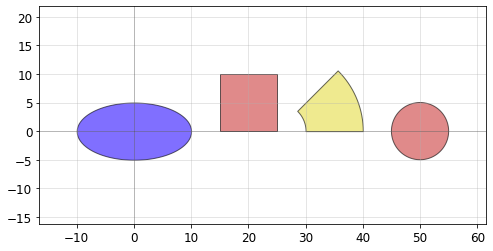

In [24]:
D = Device()

D << pg.ellipse(layer = 1)
D << pg.rectangle(size = (10,10), layer = 2).movex(15)
D << pg.arc(width = 10, layer = 3).movex(25)
D << pg.circle(radius = 5, layer = 2).movex(50)

qp(D)

Next, let's use `pg.extract()` to create a new Device which only has the objects on layers 1 and 2:

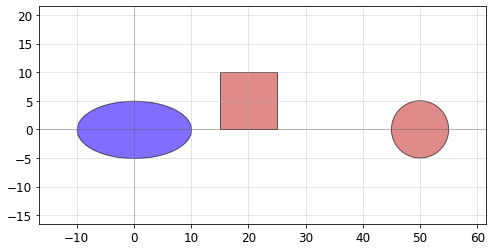

In [25]:
D_only_layers_1_and_2 = pg.extract(D, layers = [1,2])
qp(D_only_layers_1_and_2)

Note that the Device created from this function is flattened

### Copying layers to a new layer

Sometimes you want to copy a layer out of a Device AND remap that layer to a new layer in a single command.  You can do that with the `copy_layer()` function.  Let's try this out by taking the above geometry:

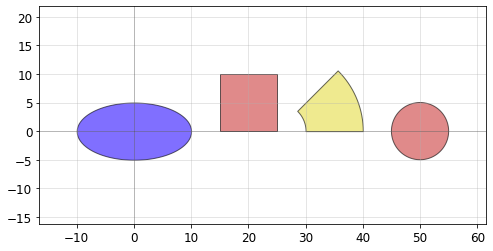

In [26]:
qp(D)

...and let's copy the arc (yellow / layer 3) arc to a new layer (blue / layer 1)

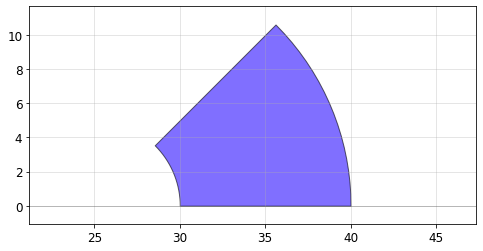

In [31]:
D_copied = pg.copy_layer(D, layer = 3, new_layer = 1)
qp(D_copied)